In [43]:
import geopandas as gpd
import pandas as pd
from sklearn.cluster import DBSCAN
import folium
import branca.colormap as cm  # Add this import
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
from shapely.ops import unary_union
import os
import openrouteservice
from sklearn.neighbors import BallTree
from shapely.geometry import Point
import logging
from shapely.geometry import shape
import numpy as np
import util
import logging
# get ORS key
ors_key = os.getenv('ORS_API_KEY')
client = openrouteservice.Client(base_url='http://localhost:8080/ors')


# import datasets
existing_isochrones = gpd.read_file('../data/derived_data/iso_merged.gpkg')
flats_pop = gpd.read_file('../data/derived_data/flats_population.gpkg')
rcps= rcps = gpd.read_file('../data/raw_data/geodata_stadt_Zuerich/recycling_sammelstellen/data/stzh.poi_sammelstelle_view.shp')
flats_duration= gpd.read_file('../data/derived_data/flats_duration.gpkg')
rcps.to_crs('EPSG:4326', inplace=True)


In [30]:
def merge_isochrones_preserve_time(isochrones_gdf):
    """
    Merge isochrones preserving lower time values.

    Parameters:
    - isochrones_gdf: GeoDataFrame with isochrones and 'time' attribute.

    Returns:
    - GeoDataFrame with merged isochrones.
    """
    # Ensure CRS is EPSG:4326
    if isochrones_gdf.crs != "EPSG:4326":
        isochrones_gdf = isochrones_gdf.to_crs(epsg=4326)

    # Sort isochrones by 'time' ascending
    isochrones_sorted = isochrones_gdf.sort_values(by='time')

    merged_isochrones = gpd.GeoDataFrame(columns=isochrones_sorted.columns, crs="EPSG:4326")

    # Initialize an empty geometry for subtraction
    accumulated_geom = None

    for _, row in isochrones_sorted.iterrows():
        current_geom = row.geometry
        current_time = row['time']

        if accumulated_geom:
            remaining_geom = current_geom.difference(accumulated_geom)
        else:
            remaining_geom = current_geom

        if not remaining_geom.is_empty:
            new_row = row.copy()
            new_row.geometry = remaining_geom
            # Ensure the new_row GeoDataFrame has the correct CRS
            new_row = gpd.GeoDataFrame([new_row], crs="EPSG:4326")
            merged_isochrones = pd.concat([merged_isochrones, new_row], ignore_index=True)
            # Update accumulated geometry
            if accumulated_geom:
                accumulated_geom = unary_union([accumulated_geom, remaining_geom])
            else:
                accumulated_geom = remaining_geom
    return merged_isochrones


merged_isochrones = merge_isochrones_preserve_time(existing_isochrones)
merged_isochrones.to_file('../data/derived_data/merged_isochrones.gpkg', driver='GPKG')

In [31]:
centroid = merged_isochrones.geometry.unary_union.centroid

# Initialize the folium map centered on the centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=13)

# Convert 'time' column to numeric
merged_isochrones['time'] = pd.to_numeric(merged_isochrones['time'])

# Define a colormap based on time
colormap = cm.LinearColormap(
    colors=['blue', 'green', 'yellow', 'red'],
    vmin=merged_isochrones['time'].min(),
    vmax=merged_isochrones['time'].max(),
    caption='Isochrone Time'
)
colormap.add_to(m)

folium.GeoJson(
    merged_isochrones,
    name='Merged Isochrones',
    style_function=lambda feature: {
        'fillColor': colormap(float(feature['properties']['time'])),
        'color': colormap(float(feature['properties']['time'])),
        'weight': 1,
        'fillOpacity': 0.5,
    }
).add_to(m)

m

In [32]:
# Reproject flats_pop to match merged_isochrones CRS
flats_pop_4326 = flats_pop.to_crs(merged_isochrones.crs)

# Merge all isochrones into a single geometry
iso_union = merged_isochrones.unary_union

# Identify flats outside any isochrones
flats_outside = flats_pop_4326[~flats_pop_4326.geometry.within(iso_union)]

print(flats_outside)
# Add flats_outside to the map
# Add flats_outside to the map using CircleMarkers
for _, row in flats_outside.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(m)

# Display the map
m

               egid   est_pop                  geometry
9284       146235.0  4.160305  POINT (8.49781 47.35829)
9285       146235.0  0.832061  POINT (8.49781 47.35829)
9286       146235.0  2.496183  POINT (8.49781 47.35829)
9287       146235.0  0.832061  POINT (8.49781 47.35829)
9288       146235.0  0.832061  POINT (8.49781 47.35829)
...             ...       ...                       ...
219105  302046185.0  2.968750  POINT (8.53777 47.33465)
225939     146249.0  0.000000  POINT (8.48993 47.35410)
226098  302003518.0  0.000000  POINT (8.48975 47.35351)
226099  302003519.0  0.000000  POINT (8.48977 47.35373)
226113  302061341.0  0.000000  POINT (8.48975 47.35327)

[1623 rows x 3 columns]


In [33]:
# Convert to centroids and set up the data for clustering
X = pd.DataFrame({
    'x': flats_outside.geometry.x,
    'y': flats_outside.geometry.y,
    'population': flats_outside['est_pop']
})

# Apply DBSCAN clustering
db = DBSCAN(eps=0.005, min_samples=20).fit(X[['x', 'y']])
X['cluster'] = db.labels_

# Remove noise points
clusters = X[X['cluster'] != -1]

# Calculate cluster centers weighted by population
cluster_centers = clusters.groupby('cluster').apply(
    lambda df: pd.Series({
        'x': (df['x'] * df['population']).sum() / df['population'].sum(),
        'y': (df['y'] * df['population']).sum() / df['population'].sum()
    })
).reset_index()

# Create GeoDataFrame for new collection points
new_points = gpd.GeoDataFrame(
    cluster_centers,
    geometry=gpd.points_from_xy(cluster_centers['x'], cluster_centers['y']),
    crs="EPSG:4326"
)
# Add new collection points to the map with larger markers
for idx, row in new_points.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=15,  # Increased from 8 to 15
        fill=True,
        color='red',
        fill_color='red',
        fill_opacity=0.7,
        popup=f'Cluster {row["cluster"]}'
    ).add_to(m)

# Display the map
m

/tmp/ipykernel_13835/607081052.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_centers = clusters.groupby('cluster').apply(


In [35]:
# Combine new points with existing rcps
# Create a simplified GeoDataFrame with only necessary columns for new points
start_id = int(max(rcps['standort_i'])) + 1
end_id = start_id + len(new_points)
new_rcps = gpd.GeoDataFrame({
    'standort_i': range(start_id, end_id),
    'adresse': ['New Location ' + str(i) for i in range(len(new_points))],
    'geometry': new_points.geometry
}, crs='EPSG:4326')

# Add other required columns with default values
for col in rcps.columns:
    if col not in new_rcps.columns:
        new_rcps[col] = None

# Combine existing and new points
all_rcps = pd.concat([rcps, new_rcps], ignore_index=True)

/tmp/ipykernel_13835/3131967459.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_rcps = pd.concat([rcps, new_rcps], ignore_index=True)


In [39]:
client = openrouteservice.Client(base_url='http://localhost:8080/ors')
# Initialize BallTree for RCP coordinates
tree, rcp_coords, rcp_ids = util.initialize_ball_tree(all_rcps, identifier_column='standort_i')

# Calculate durations for all flats to their nearest RCPs
durations = []
nearest_rcps = []

# Process each flat
for idx, flat in flats_pop_4326.iterrows():
    rcp_id, duration = util.find_nearest_rcp_duration(flat.geometry, tree, rcp_coords, rcp_ids, client)
    durations.append(duration)
    nearest_rcps.append(rcp_id)

# Add results to the flats_pop_4326 DataFrame
flats_pop_4326['nearest_rcp'] = nearest_rcps
flats_pop_4326['duration_min'] = durations

# Save the results
flats_pop_4326.to_file('../data/derived_data/flats_with_durations.gpkg', driver='GPKG')



INFO:util:BallTree initialized with RCP coordinates.


In [47]:



# Calculate metrics for new RCPs
flats_pop_4326['weighted_time'] = flats_pop_4326['duration_min'] * flats_pop_4326['est_pop']
weighted_average_time_new = flats_pop_4326['weighted_time'].sum() / flats_pop_4326['est_pop'].sum()

# Calculate metrics for original data (flats_duration)
flats_duration['weighted_time'] = flats_duration['duration'] * flats_duration['est_pop']
weighted_average_time_old = flats_duration['weighted_time'].sum() / flats_duration['est_pop'].sum()

# Calculate unserved population (≥ 10 minutes)
unserved_pop_new = flats_pop_4326[flats_pop_4326['duration_min'] >= 10]['est_pop'].sum()
unserved_pop_old = flats_duration[flats_duration['duration'] >= 10]['est_pop'].sum()

# Convert to minutes:seconds format
minutes_new = int(weighted_average_time_new)
seconds_new = int((weighted_average_time_new - minutes_new) * 60)

minutes_old = int(weighted_average_time_old)
seconds_old = int(weighted_average_time_old - minutes_old) * 60

print(f"New RCPs installed: {len(new_rcps)}")
print(f"\nComparison of metrics:")
print(f"Original weighted average walking time: {minutes_old}:{seconds_old:02d}")
print(f"New weighted average walking time: {minutes_new}:{seconds_new:02d}")
print(f"\nOriginal population with walking time >= 10 minutes: {unserved_pop_old:.0f}")
print(f"New population with walking time >= 10 minutes: {unserved_pop_new:.0f}")
print(f"\nPercentage of total population with walking time >= 10 minutes:")
total_pop = flats_pop['est_pop'].sum()
print(f"Original: {(unserved_pop_old/total_pop)*100:.1f}%")
print(f"New: {(unserved_pop_new/total_pop)*100:.1f}%")

New RCPs installed: 10

Comparison of metrics:
Original weighted average walking time: 4:00
New weighted average walking time: 3:56

Original population with walking time >= 10 minutes: 9183
New population with walking time >= 10 minutes: 3767

Percentage of total population with walking time >= 10 minutes:
Original: 2.1%
New: 0.8%


/tmp/ipykernel_13835/3529574391.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=['Before intervention', 'After intervention'])


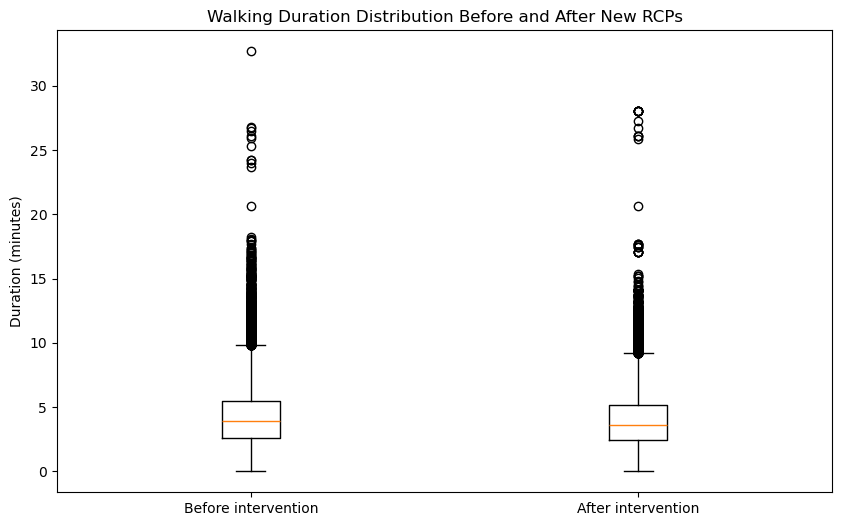

In [48]:
import matplotlib.pyplot as plt

# Create a figure
plt.figure(figsize=(10,6))

# Create boxplots
boxplot_data = [
    flats_duration['duration'],
    flats_pop_4326['duration_min']
]

plt.boxplot(boxplot_data, labels=['Before intervention', 'After intervention'])

# Customize the plot
plt.title('Walking Duration Distribution Before and After New RCPs')
plt.ylabel('Duration (minutes)')

# Show the plot
plt.show()